# 03 CycleGAN训练实验

- CycleGAN模型训练（Label ↔ Photo双向转换）
- 循环一致性损失
- 与Pix2Pix对比分析


In [1]:
# 测试环境 - 分步验证
import sys
print("Python 路径:", sys.executable)
print("Python 版本:", sys.version)
print("✅ 基础环境正常")


Python 路径: c:\Users\Ding\anaconda3\envs\autolatex-ocr-cpu\python.exe
Python 版本: 3.10.19 | packaged by Anaconda, Inc. | (main, Oct 21 2025, 16:41:31) [MSC v.1929 64 bit (AMD64)]
✅ 基础环境正常


In [2]:
# ============================================
# 本地环境设置
# ============================================

import os
from pathlib import Path
import sys

# ⚠️ 重要：在导入 torch 之前设置环境变量，避免 CUDA 初始化卡住
# 如果 GPU 检查卡住，可以临时注释掉下面这行，强制使用 CPU
# os.environ['CUDA_VISIBLE_DEVICES'] = ''  # 取消注释这行可以强制使用 CPU

# 设置项目根目录（notebooks文件夹的父目录）
ROOT = Path("..").resolve()

# 切换到项目根目录
os.chdir(ROOT)

print("✅ 本地环境设置完成！")
print(f"项目根目录：{ROOT}")
print(f"当前工作目录：{os.getcwd()}")

# 检查GPU可用性（添加异常处理，避免卡住）
print("\n正在检查GPU...")
print("提示：如果这里卡住，请中断运行，然后在代码开头添加：os.environ['CUDA_VISIBLE_DEVICES'] = ''")

try:
    import torch
    print(f"✅ PyTorch 版本: {torch.__version__}")
    
    # 尝试检查GPU（这里可能会卡住）
    try:
        cuda_available = torch.cuda.is_available()
        if cuda_available:
            print(f"✅ GPU可用: {torch.cuda.get_device_name(0)}")
            print(f"   CUDA版本: {torch.version.cuda}")
            print(f"   GPU数量: {torch.cuda.device_count()}")
        else:
            print("⚠️  警告：未检测到GPU，将使用CPU运行（速度较慢）")
    except Exception as cuda_error:
        print(f"⚠️  CUDA检查出错: {cuda_error}")
        print("   将使用CPU模式继续运行")
        
except ImportError:
    print("⚠️  警告：torch未安装，请先安装PyTorch")
except Exception as e:
    print(f"⚠️  导入torch时出错: {e}")
    print("   如果持续卡住，请尝试：")
    print("   1. 中断运行（点击停止按钮）")
    print("   2. 在代码开头添加：os.environ['CUDA_VISIBLE_DEVICES'] = ''")
    print("   3. 重新运行")

# 验证关键文件是否存在
print("\n📋 验证项目文件...")
required_files = [
    ("src/models/cyclegan_generator.py", "CycleGAN生成器"),
    ("src/models/cyclegan_discriminator.py", "CycleGAN判别器"),
    ("src/data/dataset.py", "数据集文件"),
    ("src/data/transforms.py", "数据变换文件"),
    ("data/splits/cityscapes_split_seed42.json", "数据划分文件"),
]

all_ok = True
for file_path, description in required_files:
    full_path = ROOT / file_path
    if full_path.exists():
        print(f"✅ {description}: {file_path}")
    else:
        print(f"❌ {description} 缺失: {file_path}")
        all_ok = False

if all_ok:
    print("\n🎉 所有必需文件已就绪，可以开始训练！")
else:
    print("\n⚠️  部分文件缺失，请检查项目结构")


✅ 本地环境设置完成！
项目根目录：C:\Users\Ding\Desktop\深度学习\作业二\Image-to-Image-Translation-Experiment
当前工作目录：C:\Users\Ding\Desktop\深度学习\作业二\Image-to-Image-Translation-Experiment

正在检查GPU...
提示：如果这里卡住，请中断运行，然后在代码开头添加：os.environ['CUDA_VISIBLE_DEVICES'] = ''
✅ PyTorch 版本: 2.9.1+cpu
⚠️  警告：未检测到GPU，将使用CPU运行（速度较慢）

📋 验证项目文件...
✅ CycleGAN生成器: src/models/cyclegan_generator.py
✅ CycleGAN判别器: src/models/cyclegan_discriminator.py
✅ 数据集文件: src/data/dataset.py
✅ 数据变换文件: src/data/transforms.py
✅ 数据划分文件: data/splits/cityscapes_split_seed42.json

🎉 所有必需文件已就绪，可以开始训练！


In [3]:
# 导入库
import sys
from pathlib import Path
import os

# 添加项目根目录到路径（适配Colab环境）
# 检测是否在Colab环境中运行
try:
    import google.colab
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

if IN_COLAB:
    # 在Colab中，使用之前设置的COLAB_WORK_DIR
    try:
        ROOT = COLAB_WORK_DIR
    except NameError:
        # 如果COLAB_WORK_DIR未定义，使用默认路径
        ROOT = Path("/content/Image-to-Image-Translation-Experiment")
else:
    # 本地环境：Cell 1已经切换到了项目根目录，直接使用当前工作目录
    try:
        # 尝试使用当前工作目录（Cell 1已经切换到这里）
        current_dir = Path.cwd()
        # 检查是否是项目根目录（包含data、src等文件夹）
        if (current_dir / "data").exists() and (current_dir / "src").exists():
            ROOT = current_dir
        else:
            # 如果不是，尝试相对路径
            ROOT = Path("..").resolve()
    except:
        ROOT = Path("..").resolve()

sys.path.insert(0, str(ROOT))
print(f"项目根目录：{ROOT}")
print(f"当前工作目录：{Path.cwd()}")

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from tqdm import tqdm
import json

from src.models.cyclegan_generator import CycleGANGenerator
from src.models.cyclegan_discriminator import CycleGANDiscriminator
from src.data.dataset import CityscapesDataset
from src.data.transforms import build_transform
from src.eval.metrics import evaluate_batch, calculate_psnr, calculate_ssim, calculate_mae

# 设置设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 数据路径
DATA_ROOT = ROOT / "data"
SPLIT_INDEX = ROOT / "data" / "splits" / "cityscapes_split_seed42.json"

# 输出根目录和子目录（与项目整体约定保持一致）
OUTPUT_ROOT = ROOT / "outputs"
CHECKPOINT_DIR = OUTPUT_ROOT / "checkpoints" / "cyclegan"  # 模型权重
IMAGES_DIR = OUTPUT_ROOT / "images" / "cyclegan"          # 验证三联图
FIGURES_DIR = OUTPUT_ROOT / "figures" / "cyclegan"        # 曲线、对比图
LOGS_DIR = OUTPUT_ROOT / "logs" / "cyclegan"              # 训练日志、历史

# 创建目录
for d in [CHECKPOINT_DIR, IMAGES_DIR, FIGURES_DIR, LOGS_DIR]:
    d.mkdir(parents=True, exist_ok=True)


项目根目录：C:\Users\Ding\Desktop\深度学习\作业二\Image-to-Image-Translation-Experiment
当前工作目录：C:\Users\Ding\Desktop\深度学习\作业二\Image-to-Image-Translation-Experiment
Using device: cpu


## 1. 测试CycleGAN模型架构


In [4]:
# 创建模型并测试前向传播
generator_G = CycleGANGenerator(in_channels=3, out_channels=3, n_residual_blocks=9).to(device)
generator_F = CycleGANGenerator(in_channels=3, out_channels=3, n_residual_blocks=9).to(device)
discriminator_photo = CycleGANDiscriminator(in_channels=3).to(device)
discriminator_label = CycleGANDiscriminator(in_channels=3).to(device)

generator_G.eval()
generator_F.eval()
discriminator_photo.eval()
discriminator_label.eval()

# 测试输入
label = torch.randn(1, 3, 256, 256).to(device)
photo = torch.randn(1, 3, 256, 256).to(device)

print("=" * 60)
print("CycleGAN模型架构测试")
print("=" * 60)

with torch.no_grad():
    # 生成器G（Label→Photo）
    fake_photo = generator_G(label)
    print(f"\n生成器G (Label→Photo):")
    print(f"  输入: {label.shape} → 输出: {fake_photo.shape}")
    print(f"  输出范围: [{fake_photo.min():.3f}, {fake_photo.max():.3f}] (期望: [-1, 1])")
    
    # 生成器F（Photo→Label）
    fake_label = generator_F(photo)
    print(f"\n生成器F (Photo→Label):")
    print(f"  输入: {photo.shape} → 输出: {fake_label.shape}")
    print(f"  输出范围: [{fake_label.min():.3f}, {fake_label.max():.3f}] (期望: [-1, 1])")
    
    # 循环一致性测试
    recovered_label = generator_F(fake_photo)
    recovered_photo = generator_G(fake_label)
    print(f"\n循环一致性测试:")
    print(f"  Label→Photo→Label: {label.shape} → {recovered_label.shape}")
    print(f"  Photo→Label→Photo: {photo.shape} → {recovered_photo.shape}")
    
    # 判别器测试
    pred_real_photo = discriminator_photo(photo)
    pred_fake_photo = discriminator_photo(fake_photo)
    pred_real_label = discriminator_label(label)
    pred_fake_label = discriminator_label(fake_label)
    
    print(f"\n判别器D_photo:")
    print(f"  真实photo: {pred_real_photo.shape}")
    print(f"  生成photo: {pred_fake_photo.shape}")
    
    print(f"\n判别器D_label:")
    print(f"  真实label: {pred_real_label.shape}")
    print(f"  生成label: {pred_fake_label.shape}")

# 计算参数量
total_params_G = sum(p.numel() for p in generator_G.parameters())
total_params_F = sum(p.numel() for p in generator_F.parameters())
total_params_D_photo = sum(p.numel() for p in discriminator_photo.parameters())
total_params_D_label = sum(p.numel() for p in discriminator_label.parameters())

print(f"\n参数量统计:")
print(f"  生成器G: {total_params_G:,}")
print(f"  生成器F: {total_params_F:,}")
print(f"  判别器D_photo: {total_params_D_photo:,}")
print(f"  判别器D_label: {total_params_D_label:,}")
print(f"  总参数量: {total_params_G + total_params_F + total_params_D_photo + total_params_D_label:,}")

print("\n✅ CycleGAN模型架构测试通过！")


CycleGAN模型架构测试

生成器G (Label→Photo):
  输入: torch.Size([1, 3, 256, 256]) → 输出: torch.Size([1, 3, 256, 256])
  输出范围: [-0.966, 0.930] (期望: [-1, 1])

生成器F (Photo→Label):
  输入: torch.Size([1, 3, 256, 256]) → 输出: torch.Size([1, 3, 256, 256])
  输出范围: [-0.927, 0.950] (期望: [-1, 1])

循环一致性测试:
  Label→Photo→Label: torch.Size([1, 3, 256, 256]) → torch.Size([1, 3, 256, 256])
  Photo→Label→Photo: torch.Size([1, 3, 256, 256]) → torch.Size([1, 3, 256, 256])

判别器D_photo:
  真实photo: torch.Size([1, 1, 15, 15])
  生成photo: torch.Size([1, 1, 15, 15])

判别器D_label:
  真实label: torch.Size([1, 1, 15, 15])
  生成label: torch.Size([1, 1, 15, 15])

参数量统计:
  生成器G: 11,372,931
  生成器F: 11,372,931
  判别器D_photo: 2,765,633
  判别器D_label: 2,765,633
  总参数量: 28,277,128

✅ CycleGAN模型架构测试通过！


In [5]:
# CycleGAN数据增强配置（训练集使用强增强，验证集不使用增强）
# 根据U-Net基线实验结果，强增强在泛化指标和感观质量上均优于基础增强
# 强增强配置：jitter + 水平翻转 + 颜色抖动 + 随机缩放
train_transform = build_transform(
    image_size=256,
    jitter=True,
    horizontal_flip=True,
    color_jitter=(0.2, 0.2, 0.2, 0.05),  # (brightness, contrast, saturation, hue)
    scale_range=(0.8, 1.2),  # 随机缩放范围
    normalize_mode="tanh"
)

val_transform = build_transform(
    image_size=256,
    jitter=False,
    horizontal_flip=False,
    color_jitter=None,
    scale_range=None,
    normalize_mode="tanh"
)

# 加载数据集
train_dataset = CityscapesDataset(
    root=DATA_ROOT,
    split="train",
    split_index=SPLIT_INDEX,
    transform=train_transform
)
val_dataset = CityscapesDataset(
    root=DATA_ROOT,
    split="val",
    split_index=SPLIT_INDEX,
    transform=val_transform
)

# 在Colab中，num_workers应该设置为0以避免多进程问题
# 在本地环境中可以使用2或更多
num_workers = 0  # 在 Colab 上通常设置为 2 是安全的
train_loader = DataLoader(
    train_dataset,
    batch_size=1,  # CycleGAN论文设置batch_size=1
    shuffle=True,
    num_workers=num_workers,
    pin_memory=True if device.type == "cuda" else False
)
val_loader = DataLoader(
    val_dataset,
    batch_size=1,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=True if device.type == "cuda" else False
)

print(f"✅ 数据集加载完成！")
print(f"  训练集: {len(train_dataset)} 样本")
print(f"  验证集: {len(val_dataset)} 样本")
print(f"  Batch size: 1 (CycleGAN论文设置)")


✅ 数据集加载完成！
  训练集: 2975 样本
  验证集: 500 样本
  Batch size: 1 (CycleGAN论文设置)


## 3. 定义损失函数和训练函数


In [6]:
# GAN损失函数（使用MSE Loss替代BCE Loss，更稳定）
class GANLoss(nn.Module):
    """GAN损失函数（使用MSE Loss替代BCE Loss，更稳定）"""
    def __init__(self, target_real_label=1.0, target_fake_label=0.0):
        super(GANLoss, self).__init__()
        self.register_buffer('real_label', torch.tensor(target_real_label))
        self.register_buffer('fake_label', torch.tensor(target_fake_label))
        self.loss = nn.MSELoss()
    
    def __call__(self, prediction, target_is_real):
        if target_is_real:
            target_tensor = self.real_label
        else:
            target_tensor = self.fake_label
        
        # 确保target_tensor与prediction在同一个设备上
        target_tensor = target_tensor.to(prediction.device).expand_as(prediction)
        loss = self.loss(prediction, target_tensor)
        return loss


def save_triplet(label, generated, ground_truth, save_path, title="Label | Generated | Ground Truth"):
    """保存三联图：Label / Generated / Ground Truth"""
    def tensor_to_image(tensor):
        if tensor.dim() == 3:
            img = tensor.permute(1, 2, 0).cpu().numpy()
        else:
            img = tensor[0].permute(1, 2, 0).cpu().numpy()
        if img.min() < 0:
            img = (img + 1) / 2
        img = np.clip(img, 0, 1)
        img = (img * 255).astype(np.uint8)
        return img
    
    label_img = tensor_to_image(label)
    gen_img = tensor_to_image(generated)
    gt_img = tensor_to_image(ground_truth)
    
    triplet = np.hstack([label_img, gen_img, gt_img])
    Image.fromarray(triplet).save(save_path)


def save_cycle_triplet(label, fake_photo, recovered_label, photo, fake_label, recovered_photo, save_path):
    """保存CycleGAN的双向循环结果"""
    def tensor_to_image(tensor):
        if tensor.dim() == 3:
            img = tensor.permute(1, 2, 0).cpu().numpy()
        else:
            img = tensor[0].permute(1, 2, 0).cpu().numpy()
        if img.min() < 0:
            img = (img + 1) / 2
        img = np.clip(img, 0, 1)
        img = (img * 255).astype(np.uint8)
        return img
    
    label_img = tensor_to_image(label)
    fake_photo_img = tensor_to_image(fake_photo)
    recovered_label_img = tensor_to_image(recovered_label)
    photo_img = tensor_to_image(photo)
    fake_label_img = tensor_to_image(fake_label)
    recovered_photo_img = tensor_to_image(recovered_photo)
    
    # 第一行：Label → Photo → Label
    row1 = np.hstack([label_img, fake_photo_img, recovered_label_img])
    # 第二行：Photo → Label → Photo
    row2 = np.hstack([photo_img, fake_label_img, recovered_photo_img])
    # 垂直拼接
    cycle_result = np.vstack([row1, row2])
    Image.fromarray(cycle_result).save(save_path)


print("✅ 损失函数和工具函数定义完成！")


✅ 损失函数和工具函数定义完成！


In [7]:
def train_epoch(
    generator_G, generator_F,
    discriminator_photo, discriminator_label,
    dataloader, gan_loss, l1_loss,
    optimizer_G, optimizer_F,
    optimizer_D_photo, optimizer_D_label,
    device, epoch, lambda_cycle=10.0, lambda_identity=0.5
):
    """训练一个epoch"""
    generator_G.train()
    generator_F.train()
    discriminator_photo.train()
    discriminator_label.train()
    
    total_loss_G = 0.0
    total_loss_F = 0.0
    total_loss_D_photo = 0.0
    total_loss_D_label = 0.0
    total_loss_cycle = 0.0
    num_batches = 0
    
    pbar = tqdm(dataloader, desc=f"Epoch {epoch} [Train]")
    for batch_idx, batch in enumerate(pbar):
        label = batch["label"].to(device)
        photo = batch["photo"].to(device)
        
        batch_size = label.size(0)
        
        # ========== 训练判别器 D_photo ==========
        optimizer_D_photo.zero_grad()
        
        # 真实photo
        real_photo = photo
        pred_real_photo = discriminator_photo(real_photo)
        loss_D_photo_real = gan_loss(pred_real_photo, True)
        
        # 生成photo（detach，不更新生成器）
        fake_photo = generator_G(label.detach())
        pred_fake_photo = discriminator_photo(fake_photo.detach())
        loss_D_photo_fake = gan_loss(pred_fake_photo, False)
        
        # 判别器总损失
        loss_D_photo = (loss_D_photo_real + loss_D_photo_fake) * 0.5
        loss_D_photo.backward()
        optimizer_D_photo.step()
        
        # ========== 训练判别器 D_label ==========
        optimizer_D_label.zero_grad()
        
        # 真实label
        real_label = label
        pred_real_label = discriminator_label(real_label)
        loss_D_label_real = gan_loss(pred_real_label, True)
        
        # 生成label（detach，不更新生成器）
        fake_label = generator_F(photo.detach())
        pred_fake_label = discriminator_label(fake_label.detach())
        loss_D_label_fake = gan_loss(pred_fake_label, False)
        
        # 判别器总损失
        loss_D_label = (loss_D_label_real + loss_D_label_fake) * 0.5
        loss_D_label.backward()
        optimizer_D_label.step()
        
        # ========== 训练生成器 G 和 F ==========
        optimizer_G.zero_grad()
        optimizer_F.zero_grad()
        
        # 对抗损失
        fake_photo = generator_G(label)
        pred_fake_photo = discriminator_photo(fake_photo)
        loss_GAN_G = gan_loss(pred_fake_photo, True)
        
        fake_label = generator_F(photo)
        pred_fake_label = discriminator_label(fake_label)
        loss_GAN_F = gan_loss(pred_fake_label, True)
        
        # 循环一致性损失
        # 前向循环：label -> G(label) -> F(G(label)) -> label
        recovered_label = generator_F(fake_photo)
        loss_cycle_forward = l1_loss(recovered_label, label) * lambda_cycle
        
        # 后向循环：photo -> F(photo) -> G(F(photo)) -> photo
        recovered_photo = generator_G(fake_label)
        loss_cycle_backward = l1_loss(recovered_photo, photo) * lambda_cycle
        
        # 身份损失（可选）
        if lambda_identity > 0:
            # G(photo) ≈ photo, F(label) ≈ label
            identity_photo = generator_G(photo)
            loss_identity_G = l1_loss(identity_photo, photo) * lambda_identity
            
            identity_label = generator_F(label)
            loss_identity_F = l1_loss(identity_label, label) * lambda_identity
        else:
            loss_identity_G = torch.tensor(0.0, device=device)
            loss_identity_F = torch.tensor(0.0, device=device)
        
        # 生成器总损失
        # loss_G: GAN损失 + 后向循环损失（G(F(photo))） + 身份损失
        # 注意：loss_cycle_backward 依赖于 fake_label（来自generator_F），
        # 但我们需要梯度只通过 generator_G，所以需要重新计算
        # 实际上，loss_cycle_backward 应该只对 generator_G 求梯度
        
        # 方法：分别计算两个生成器的损失，使用 retain_graph=True 来保留计算图
        # 或者：重新组织计算，让每个损失只依赖一个生成器
        
        # 重新计算以分离计算图：
        # 对于 generator_G：需要 loss_cycle_backward，但 fake_label 应该 detach
        fake_label_detached = fake_label.detach()
        recovered_photo_G = generator_G(fake_label_detached)
        loss_cycle_backward_G = l1_loss(recovered_photo_G, photo) * lambda_cycle
        
        # 对于 generator_F：需要 loss_cycle_forward，但 fake_photo 应该 detach
        fake_photo_detached = fake_photo.detach()
        recovered_label_F = generator_F(fake_photo_detached)
        loss_cycle_forward_F = l1_loss(recovered_label_F, label) * lambda_cycle
        
        # 生成器总损失
        loss_G = loss_GAN_G + loss_cycle_backward_G + loss_identity_G
        loss_F = loss_GAN_F + loss_cycle_forward_F + loss_identity_F
        
        # 分别反向传播
        loss_G.backward()
        loss_F.backward()
        
        optimizer_G.step()
        optimizer_F.step()
        
        # 记录损失
        total_loss_G += loss_G.item()
        total_loss_F += loss_F.item()
        total_loss_D_photo += loss_D_photo.item()
        total_loss_D_label += loss_D_label.item()
        # 记录总循环损失（用于显示，使用原始计算的值）
        total_loss_cycle += (loss_cycle_forward.item() + loss_cycle_backward.item())
        num_batches += 1
        
        # 更新进度条
        cycle_loss_total = loss_cycle_forward.item() + loss_cycle_backward.item()
        pbar.set_postfix({
            "G": f"{loss_G.item():.4f}",
            "F": f"{loss_F.item():.4f}",
            "D_photo": f"{loss_D_photo.item():.4f}",
            "D_label": f"{loss_D_label.item():.4f}",
            "Cycle": f"{cycle_loss_total:.4f}",
        })
    
    avg_loss_G = total_loss_G / num_batches if num_batches > 0 else 0.0
    avg_loss_F = total_loss_F / num_batches if num_batches > 0 else 0.0
    avg_loss_D_photo = total_loss_D_photo / num_batches if num_batches > 0 else 0.0
    avg_loss_D_label = total_loss_D_label / num_batches if num_batches > 0 else 0.0
    avg_loss_cycle = total_loss_cycle / num_batches if num_batches > 0 else 0.0
    
    return {
        "loss_G": avg_loss_G,
        "loss_F": avg_loss_F,
        "loss_D_photo": avg_loss_D_photo,
        "loss_D_label": avg_loss_D_label,
        "loss_cycle": avg_loss_cycle,
    }


@torch.no_grad()
def validate(
    generator_G, generator_F,
    dataloader, l1_loss, device, epoch, output_dir,
    num_samples=10
):
    """验证并保存三联图"""
    generator_G.eval()
    generator_F.eval()
    
    total_loss_cycle = 0.0
    total_metrics = {"psnr": 0.0, "ssim": 0.0, "mae": 0.0}
    num_batches = 0
    saved_samples = 0
    
    pbar = tqdm(dataloader, desc=f"Epoch {epoch} [Val]")
    for batch_idx, batch in enumerate(pbar):
        label = batch["label"].to(device)
        photo = batch["photo"].to(device)
        name = batch["name"]
        
        # 前向传播
        fake_photo = generator_G(label)
        fake_label = generator_F(photo)
        
        # 循环一致性
        recovered_label = generator_F(fake_photo)
        recovered_photo = generator_G(fake_label)
        
        loss_cycle_forward = l1_loss(recovered_label, label)
        loss_cycle_backward = l1_loss(recovered_photo, photo)
        loss_cycle = loss_cycle_forward + loss_cycle_backward
        
        total_loss_cycle += loss_cycle.item()
        
        # 评估指标（Label→Photo方向）
        metrics = evaluate_batch(fake_photo, photo)
        for key in total_metrics:
            total_metrics[key] += metrics[key]
        
        num_batches += 1
        
        # 保存前num_samples个样本的三联图
        if saved_samples < num_samples:
            # Label→Photo方向
            save_path = output_dir / "images" / f"epoch_{epoch:03d}_sample_{saved_samples:02d}_label2photo.png"
            save_path.parent.mkdir(parents=True, exist_ok=True)
            save_triplet(label, fake_photo, photo, save_path, "Label | Generated Photo | Ground Truth Photo")
            
            # Photo→Label方向
            save_path = output_dir / "images" / f"epoch_{epoch:03d}_sample_{saved_samples:02d}_photo2label.png"
            save_triplet(photo, fake_label, label, save_path, "Photo | Generated Label | Ground Truth Label")
            
            # 循环一致性结果
            save_path = output_dir / "images" / f"epoch_{epoch:03d}_sample_{saved_samples:02d}_cycle.png"
            save_cycle_triplet(
                label, fake_photo, recovered_label,
                photo, fake_label, recovered_photo,
                save_path
            )
            
            saved_samples += 1
        
        pbar.set_postfix({
            "cycle_loss": f"{loss_cycle.item():.4f}",
            "psnr": f"{metrics['psnr']:.2f}",
        })
    
    avg_loss_cycle = total_loss_cycle / num_batches if num_batches > 0 else 0.0
    avg_metrics = {key: val / num_batches for key, val in total_metrics.items()}
    
    return avg_loss_cycle, avg_metrics


print("✅ 训练和验证函数定义完成！")


✅ 训练和验证函数定义完成！


In [8]:
# ============================================
# 训练配置
# ============================================
from pathlib import Path
epochs = 110
batch_size = 1  # CycleGAN论文设置
lr = 2e-4
start_decay_epoch = 100
lambda_cycle = 10.0
lambda_identity = 0.5
n_residual_blocks = 9

# 创建模型
print("创建模型...")
generator_G = CycleGANGenerator(
    in_channels=3,
    out_channels=3,
    n_residual_blocks=n_residual_blocks
).to(device)
generator_F = CycleGANGenerator(
    in_channels=3,
    out_channels=3,
    n_residual_blocks=n_residual_blocks
).to(device)
discriminator_photo = CycleGANDiscriminator(in_channels=3).to(device)
discriminator_label = CycleGANDiscriminator(in_channels=3).to(device)

# 损失函数和优化器
gan_loss = GANLoss()
l1_loss = nn.L1Loss()

optimizer_G = optim.Adam(generator_G.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_F = optim.Adam(generator_F.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D_photo = optim.Adam(discriminator_photo.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D_label = optim.Adam(discriminator_label.parameters(), lr=lr, betas=(0.5, 0.999))

# 学习率调度
def get_lr_scheduler(optimizer, num_epochs, start_decay_epoch):
    def lr_lambda(epoch):
        if epoch < start_decay_epoch:
            return 1.0
        else:
            return 1.0 - (epoch - start_decay_epoch) / (num_epochs - start_decay_epoch)
    return optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

scheduler_G = get_lr_scheduler(optimizer_G, epochs, start_decay_epoch)
scheduler_F = get_lr_scheduler(optimizer_F, epochs, start_decay_epoch)
scheduler_D_photo = get_lr_scheduler(optimizer_D_photo, epochs, start_decay_epoch)
scheduler_D_label = get_lr_scheduler(optimizer_D_label, epochs, start_decay_epoch)

# ============================================
# 恢复训练（从checkpoint继续）
# ============================================
# 指定要恢复的checkpoint路径（修改为你实际保存的checkpoint文件名）
resume_checkpoint = CHECKPOINT_DIR / "checkpoint_epoch_110.pth"  # CHECKPOINT_DIR / "checkpoint_epoch_050.pth"
start_epoch = 1

# 初始化训练历史列表
train_losses_G = []
train_losses_F = []
train_losses_D_photo = []
train_losses_D_label = []
train_losses_cycle = []
val_losses_cycle = []
val_psnrs = []
val_ssims = []
val_maes = []

# 尝试从checkpoint恢复
if resume_checkpoint is not None and resume_checkpoint.exists():
    print(f"🔁 恢复训练自: {resume_checkpoint}")
    checkpoint = torch.load(resume_checkpoint, map_location=device, weights_only=False)
    
    # 恢复模型和优化器状态
    generator_G.load_state_dict(checkpoint["generator_G_state_dict"])
    generator_F.load_state_dict(checkpoint["generator_F_state_dict"])
    discriminator_photo.load_state_dict(checkpoint["discriminator_photo_state_dict"])
    discriminator_label.load_state_dict(checkpoint["discriminator_label_state_dict"])
    optimizer_G.load_state_dict(checkpoint["optimizer_G_state_dict"])
    optimizer_F.load_state_dict(checkpoint["optimizer_F_state_dict"])
    optimizer_D_photo.load_state_dict(checkpoint["optimizer_D_photo_state_dict"])
    optimizer_D_label.load_state_dict(checkpoint["optimizer_D_label_state_dict"])
    start_epoch = checkpoint["epoch"] + 1  # 从下一个epoch开始
    
    # 恢复scheduler状态（需要手动调整到正确的epoch）
    for _ in range(start_epoch - 1):
        scheduler_G.step()
        scheduler_F.step()
        scheduler_D_photo.step()
        scheduler_D_label.step()
    
    # 尝试从history JSON恢复训练历史（如果存在）
    history_path = LOGS_DIR / "history.json"
    if history_path.exists():
        with open(history_path, "r") as f:
            history = json.load(f)
        train_losses_G = history.get("train_losses_G", [])
        train_losses_F = history.get("train_losses_F", [])
        train_losses_D_photo = history.get("train_losses_D_photo", [])
        train_losses_D_label = history.get("train_losses_D_label", [])
        train_losses_cycle = history.get("train_losses_cycle", [])
        val_losses_cycle = history.get("val_losses_cycle", [])
        val_psnrs = history.get("val_psnrs", [])
        val_ssims = history.get("val_ssims", [])
        val_maes = history.get("val_maes", [])
        print(f"✅ 已恢复训练历史（{len(train_losses_G)} 个epoch）")
    
    print(f"📌 将从 Epoch {start_epoch} 继续训练到 Epoch {epochs}")
else:
    print(f"⚠️  未找到checkpoint或未指定checkpoint")
    print("   将从 Epoch 1 开始全新训练")

print(f"\n🚀 Starting CycleGAN training...")
print(f"   Epochs: {epochs}, Batch size: {batch_size}, LR: {lr}")
print(f"   Lambda cycle: {lambda_cycle}, Lambda identity: {lambda_identity}")
print(f"   Residual blocks: {n_residual_blocks}")

# 训练循环
best_val_psnr = 0.0

for epoch in range(start_epoch, epochs + 1):
    # 训练
    train_losses = train_epoch(
        generator_G, generator_F,
        discriminator_photo, discriminator_label,
        train_loader, gan_loss, l1_loss,
        optimizer_G, optimizer_F,
        optimizer_D_photo, optimizer_D_label,
        device, epoch,
        lambda_cycle=lambda_cycle,
        lambda_identity=lambda_identity
    )
    
    # 验证
    val_loss_cycle, val_metrics = validate(
        generator_G, generator_F,
        val_loader, l1_loss, device, epoch, OUTPUT_ROOT / "cyclegan",
        num_samples=10
    )
    
    # 学习率调度
    scheduler_G.step()
    scheduler_F.step()
    scheduler_D_photo.step()
    scheduler_D_label.step()
    current_lr = optimizer_G.param_groups[0]["lr"]
    
    # 记录历史
    train_losses_G.append(train_losses["loss_G"])
    train_losses_F.append(train_losses["loss_F"])
    train_losses_D_photo.append(train_losses["loss_D_photo"])
    train_losses_D_label.append(train_losses["loss_D_label"])
    train_losses_cycle.append(train_losses["loss_cycle"])
    val_losses_cycle.append(val_loss_cycle)
    val_psnrs.append(val_metrics["psnr"])
    val_ssims.append(val_metrics["ssim"])
    val_maes.append(val_metrics["mae"])
    
    if epoch % 10 == 0:
        print(f"\nEpoch {epoch}/{epochs}")
        print(f"  Train - G: {train_losses['loss_G']:.4f}, F: {train_losses['loss_F']:.4f}, "
              f"D_photo: {train_losses['loss_D_photo']:.4f}, D_label: {train_losses['loss_D_label']:.4f}, "
              f"Cycle: {train_losses['loss_cycle']:.4f}")
        print(f"  Val - Cycle Loss: {val_loss_cycle:.4f}, PSNR: {val_metrics['psnr']:.2f}dB, "
              f"SSIM: {val_metrics['ssim']:.4f}, MAE: {val_metrics['mae']:.4f}, LR: {current_lr:.6f}")
        
        # 保存checkpoint
        torch.save({
            "epoch": epoch,
            "generator_G_state_dict": generator_G.state_dict(),
            "generator_F_state_dict": generator_F.state_dict(),
            "discriminator_photo_state_dict": discriminator_photo.state_dict(),
            "discriminator_label_state_dict": discriminator_label.state_dict(),
            "optimizer_G_state_dict": optimizer_G.state_dict(),
            "optimizer_F_state_dict": optimizer_F.state_dict(),
            "optimizer_D_photo_state_dict": optimizer_D_photo.state_dict(),
            "optimizer_D_label_state_dict": optimizer_D_label.state_dict(),
            "scheduler_G_state_dict": scheduler_G.state_dict(),
            "scheduler_F_state_dict": scheduler_F.state_dict(),
            "scheduler_D_photo_state_dict": scheduler_D_photo.state_dict(),
            "scheduler_D_label_state_dict": scheduler_D_label.state_dict(),
            "val_psnr": val_metrics["psnr"],
            "val_ssim": val_metrics["ssim"],
            "val_mae": val_metrics["mae"],
        }, CHECKPOINT_DIR / f"checkpoint_epoch_{epoch:03d}.pth")
        
        # 保存训练历史
        history = {
            "train_losses_G": train_losses_G,
            "train_losses_F": train_losses_F,
            "train_losses_D_photo": train_losses_D_photo,
            "train_losses_D_label": train_losses_D_label,
            "train_losses_cycle": train_losses_cycle,
            "val_losses_cycle": val_losses_cycle,
            "val_psnrs": val_psnrs,
            "val_ssims": val_ssims,
            "val_maes": val_maes,
        }
        with open(LOGS_DIR / "history.json", "w") as f:
            json.dump(history, f, indent=2)

# 保存最终模型
torch.save({
    "generator_G_state_dict": generator_G.state_dict(),
    "generator_F_state_dict": generator_F.state_dict(),
    "discriminator_photo_state_dict": discriminator_photo.state_dict(),
    "discriminator_label_state_dict": discriminator_label.state_dict(),
}, CHECKPOINT_DIR / "model_final.pth")

print(f"\n✅ Training complete!")
print(f"   Final Val Cycle Loss: {val_losses_cycle[-1]:.4f}")
print(f"   Final PSNR: {val_psnrs[-1]:.2f}dB")
print(f"   Final SSIM: {val_ssims[-1]:.4f}")
print(f"   Final MAE: {val_maes[-1]:.4f}")


创建模型...
🔁 恢复训练自: C:\Users\Ding\Desktop\深度学习\作业二\Image-to-Image-Translation-Experiment\outputs\checkpoints\cyclegan\checkpoint_epoch_110.pth
✅ 已恢复训练历史（110 个epoch）
📌 将从 Epoch 111 继续训练到 Epoch 110

🚀 Starting CycleGAN training...
   Epochs: 110, Batch size: 1, LR: 0.0002
   Lambda cycle: 10.0, Lambda identity: 0.5
   Residual blocks: 9

✅ Training complete!
   Final Val Cycle Loss: 0.2079
   Final PSNR: 17.28dB
   Final SSIM: 0.5066
   Final MAE: 0.0973


c:\Users\Ding\anaconda3\envs\autolatex-ocr-cpu\lib\site-packages\torch\optim\lr_scheduler.py:192: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


✅ 已加载训练历史（110 个epoch）


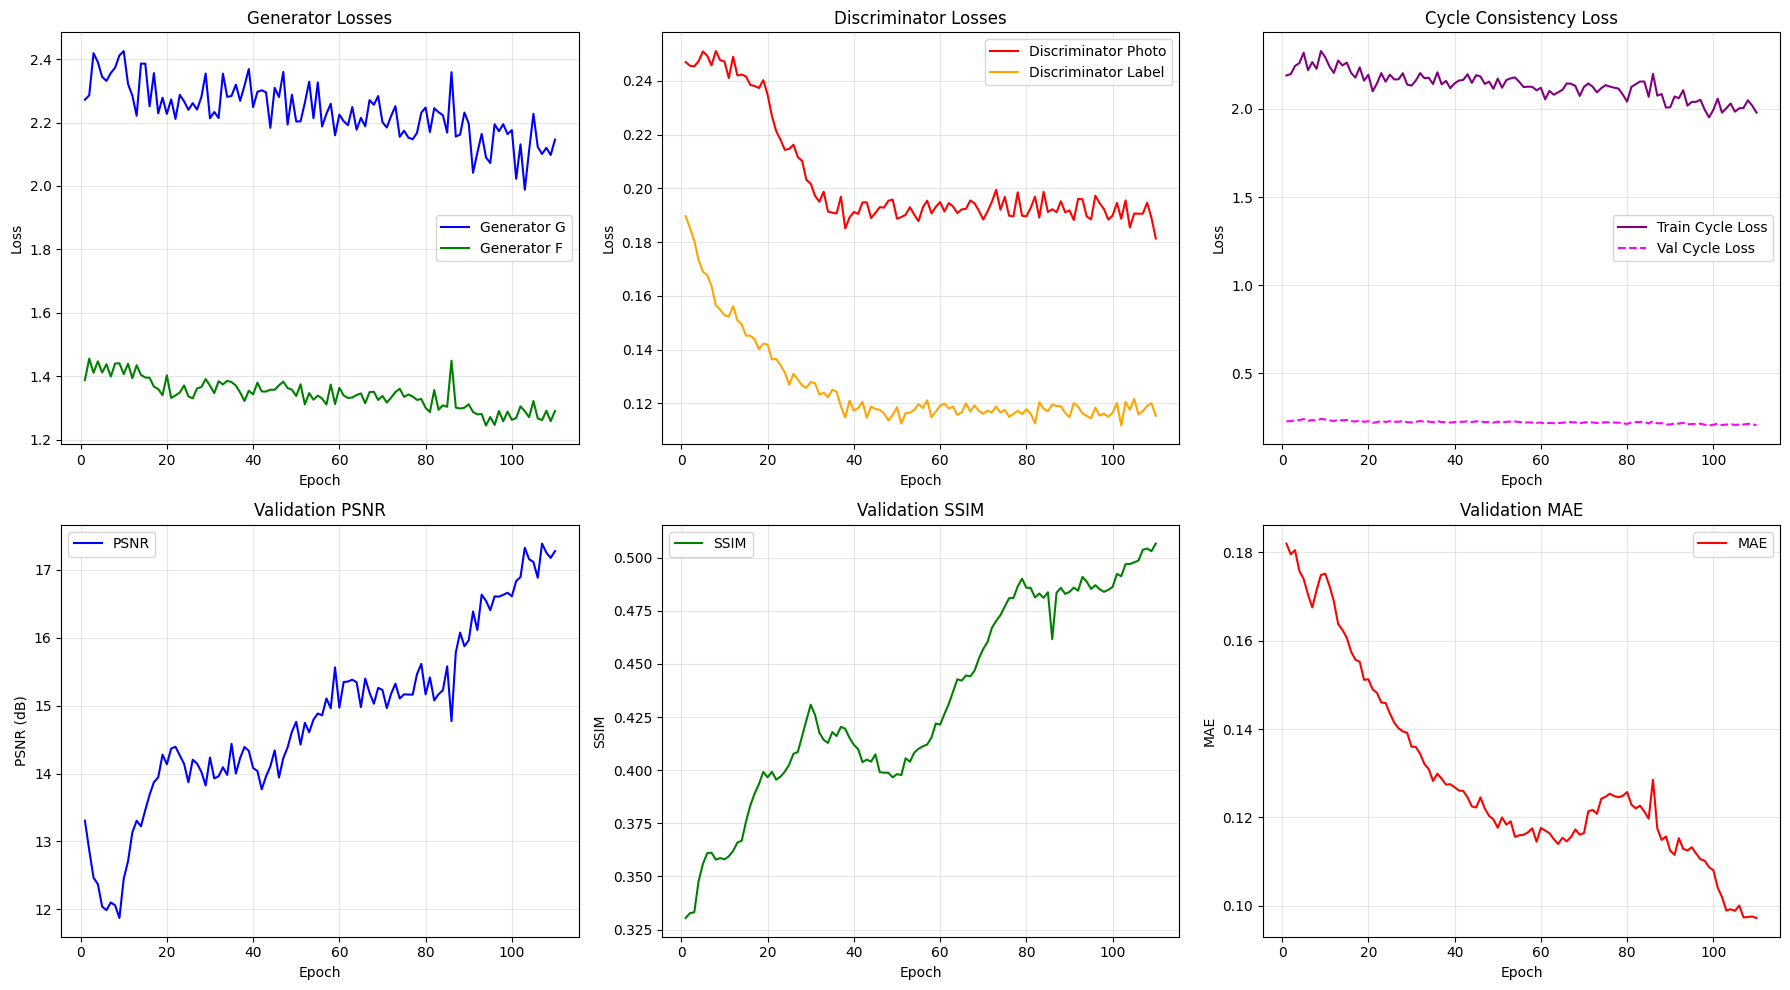

✅ 图表绘制完成！


In [9]:
# 修复：从文件加载训练历史并绘制曲线
import json
from pathlib import Path

# 设置路径
LOGS_DIR = Path("outputs/logs/cyclegan")
FIGURES_DIR = Path("outputs/figures/cyclegan")
FIGURES_DIR.mkdir(parents=True, exist_ok=True)

# 加载历史数据
history_path = LOGS_DIR / "history.json"

if history_path.exists():
    with open(history_path, "r") as f:
        history = json.load(f)
    
    train_losses_G = history.get("train_losses_G", [])
    train_losses_F = history.get("train_losses_F", [])
    train_losses_D_photo = history.get("train_losses_D_photo", [])
    train_losses_D_label = history.get("train_losses_D_label", [])
    train_losses_cycle = history.get("train_losses_cycle", [])
    val_losses_cycle = history.get("val_losses_cycle", [])
    val_psnrs = history.get("val_psnrs", [])
    val_ssims = history.get("val_ssims", [])
    val_maes = history.get("val_maes", [])
    
    print(f"✅ 已加载训练历史（{len(train_losses_G)} 个epoch）")
    
    # 绘制训练损失曲线
    if len(train_losses_G) > 0:
        fig, axes = plt.subplots(2, 3, figsize=(18, 10))
        
        epochs_range = range(1, len(train_losses_G) + 1)
        
        # 生成器损失
        axes[0, 0].plot(epochs_range, train_losses_G, label="Generator G", color="blue")
        axes[0, 0].plot(epochs_range, train_losses_F, label="Generator F", color="green")
        axes[0, 0].set_xlabel("Epoch")
        axes[0, 0].set_ylabel("Loss")
        axes[0, 0].set_title("Generator Losses")
        axes[0, 0].legend()
        axes[0, 0].grid(True, alpha=0.3)
        
        # 判别器损失
        axes[0, 1].plot(epochs_range, train_losses_D_photo, label="Discriminator Photo", color="red")
        axes[0, 1].plot(epochs_range, train_losses_D_label, label="Discriminator Label", color="orange")
        axes[0, 1].set_xlabel("Epoch")
        axes[0, 1].set_ylabel("Loss")
        axes[0, 1].set_title("Discriminator Losses")
        axes[0, 1].legend()
        axes[0, 1].grid(True, alpha=0.3)
        
        # 循环一致性损失
        axes[0, 2].plot(epochs_range, train_losses_cycle, label="Train Cycle Loss", color="purple")
        axes[0, 2].plot(epochs_range, val_losses_cycle, label="Val Cycle Loss", color="magenta", linestyle="--")
        axes[0, 2].set_xlabel("Epoch")
        axes[0, 2].set_ylabel("Loss")
        axes[0, 2].set_title("Cycle Consistency Loss")
        axes[0, 2].legend()
        axes[0, 2].grid(True, alpha=0.3)
        
        # PSNR
        axes[1, 0].plot(epochs_range, val_psnrs, label="PSNR", color="blue")
        axes[1, 0].set_xlabel("Epoch")
        axes[1, 0].set_ylabel("PSNR (dB)")
        axes[1, 0].set_title("Validation PSNR")
        axes[1, 0].legend()
        axes[1, 0].grid(True, alpha=0.3)
        
        # SSIM
        axes[1, 1].plot(epochs_range, val_ssims, label="SSIM", color="green")
        axes[1, 1].set_xlabel("Epoch")
        axes[1, 1].set_ylabel("SSIM")
        axes[1, 1].set_title("Validation SSIM")
        axes[1, 1].legend()
        axes[1, 1].grid(True, alpha=0.3)
        
        # MAE
        axes[1, 2].plot(epochs_range, val_maes, label="MAE", color="red")
        axes[1, 2].set_xlabel("Epoch")
        axes[1, 2].set_ylabel("MAE")
        axes[1, 2].set_title("Validation MAE")
        axes[1, 2].legend()
        axes[1, 2].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.savefig(FIGURES_DIR / "training_curves.png", dpi=150, bbox_inches="tight")
        plt.show()
        
        print("✅ 图表绘制完成！")
    else:
        print("❌ 没有训练历史数据")
else:
    print(f"❌ 未找到历史文件: {history_path}")

In [13]:
# ============================================
# 生成110epoch的三联图样例
# ============================================
print("🚀 生成110epoch的三联图样例...")

# 设置路径
from pathlib import Path
CHECKPOINT_DIR = Path("outputs/checkpoints/cyclegan")
IMAGES_DIR = Path("outputs/images/cyclegan")
FIGURES_DIR = Path("outputs/figures/cyclegan")
FIGURES_DIR.mkdir(parents=True, exist_ok=True)

# 加载110epoch的checkpoint
checkpoint_path = CHECKPOINT_DIR / "checkpoint_epoch_110.pth"
if checkpoint_path.exists():
    checkpoint = torch.load(checkpoint_path, map_location=device, weights_only=False)
    
    # 创建临时模型并加载权重
    from src.models.cyclegan_generator import CycleGANGenerator  # 修正导入路径
    temp_generator_G = CycleGANGenerator(in_channels=3, out_channels=3, n_residual_blocks=9).to(device)
    temp_generator_F = CycleGANGenerator(in_channels=3, out_channels=3, n_residual_blocks=9).to(device)
    
    temp_generator_G.load_state_dict(checkpoint["generator_G_state_dict"])
    temp_generator_F.load_state_dict(checkpoint["generator_F_state_dict"])
    
    temp_generator_G.eval()
    temp_generator_F.eval()
    
    # 生成110epoch的样例
    saved_samples = 0
    num_samples = 10
    
    # 直接创建验证数据加载器（与notebook中相同的方式）
    from src.data.dataset import CityscapesDataset
    from src.data.transforms import build_transform
    from torch.utils.data import DataLoader

    # 数据路径（与notebook中相同）
    DATA_ROOT = Path("data")
    SPLIT_INDEX = Path("data/splits/cityscapes_split_seed42.json")

    # 验证集变换（不使用增强）
    val_transform = build_transform(
        image_size=256,
        jitter=False,
        horizontal_flip=False,
        color_jitter=None,
        scale_range=None,
        normalize_mode="tanh"
    )

    # 创建验证数据集
    val_dataset = CityscapesDataset(
        root=DATA_ROOT,
        split="val",
        split_index=SPLIT_INDEX,
        transform=val_transform
    )

    # 创建验证数据加载器
    val_loader = DataLoader(
        val_dataset,
        batch_size=1,
        shuffle=False,
        num_workers=0,
        pin_memory=True if device.type == "cuda" else False
    )
    
    with torch.no_grad():
        val_iter = iter(val_loader)
        for i in range(num_samples):
            try:
                batch = next(val_iter)
            except StopIteration:
                val_iter = iter(val_loader)  # 重新开始迭代
                batch = next(val_iter)
            
            label = batch["label"].to(device)
            photo = batch["photo"].to(device)
            
            # 前向传播
            fake_photo = temp_generator_G(label)
            fake_label = temp_generator_F(photo)
            
            # 循环一致性
            recovered_label = temp_generator_F(fake_photo)
            recovered_photo = temp_generator_G(fake_label)
            
            # 保存三联图
            # Label→Photo方向
            save_path = IMAGES_DIR / f"epoch_110_sample_{saved_samples:02d}_label2photo.png"
            save_path.parent.mkdir(parents=True, exist_ok=True)
            save_triplet(label, fake_photo, photo, save_path, "Label | Generated Photo | Ground Truth Photo")
            
            # Photo→Label方向
            save_path = IMAGES_DIR / f"epoch_110_sample_{saved_samples:02d}_photo2label.png"
            save_triplet(photo, fake_label, label, save_path, "Photo | Generated Label | Ground Truth Label")
            
            # 循环一致性结果
            save_path = IMAGES_DIR / f"epoch_110_sample_{saved_samples:02d}_cycle.png"
            save_cycle_triplet(
                label, fake_photo, recovered_label,
                photo, fake_label, recovered_photo,
                save_path
            )
            
            saved_samples += 1
            print(f"✅ 已保存样例 {saved_samples}/{num_samples}")
    
    print(f"🎉 成功生成110epoch的{num_samples}个样例图片！")
    print(f"📁 样例保存在: {IMAGES_DIR}")
else:
    print(f"❌ Checkpoint文件不存在: {checkpoint_path}")

🚀 生成110epoch的三联图样例...
✅ 已保存样例 1/10
✅ 已保存样例 2/10
✅ 已保存样例 3/10
✅ 已保存样例 4/10
✅ 已保存样例 5/10
✅ 已保存样例 6/10
✅ 已保存样例 7/10
✅ 已保存样例 8/10
✅ 已保存样例 9/10
✅ 已保存样例 10/10
🎉 成功生成110epoch的10个样例图片！
📁 样例保存在: outputs\images\cyclegan


### 5.2 生成结果可视化


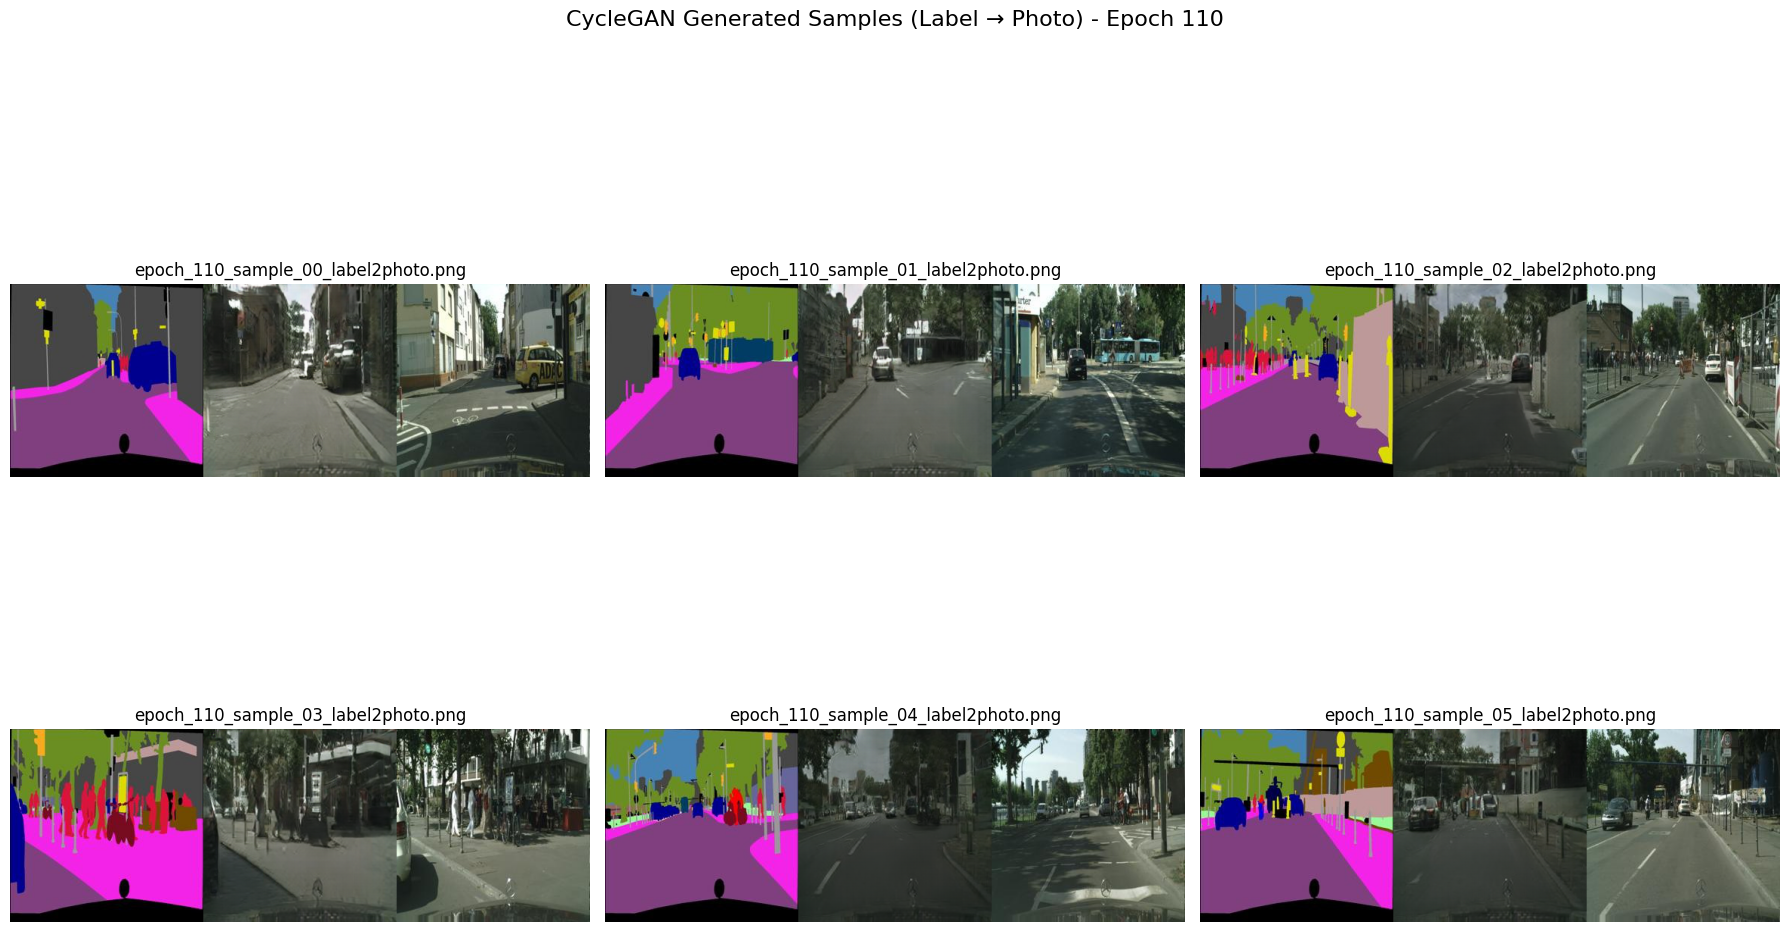

In [15]:
# 加载保存的三联图并展示
import glob

# 查找最新的epoch样例
sample_images_label2photo = sorted(glob.glob(str(IMAGES_DIR / "epoch_*_sample_*_label2photo.png")))
sample_images_cycle = sorted(glob.glob(str(IMAGES_DIR / "epoch_*_sample_*_cycle.png")))

if sample_images_label2photo:
    # 显示Label→Photo方向的样例
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle("CycleGAN Generated Samples (Label → Photo)", fontsize=16)
    
    for idx, img_path in enumerate(sample_images_label2photo[:6]):
        row = idx // 3
        col = idx % 3
        img = Image.open(img_path)
        axes[row, col].imshow(img)
        axes[row, col].set_title(f"Sample {idx + 1}")
        axes[row, col].axis("off")
    
    plt.tight_layout()
    plt.savefig(FIGURES_DIR / "samples_label2photo.png", dpi=150, bbox_inches="tight")
    plt.show()
    
    # 显示循环一致性结果
    if sample_images_cycle:
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        fig.suptitle("CycleGAN Cycle Consistency Results", fontsize=16)
        
        for idx, img_path in enumerate(sample_images_cycle[:6]):
            row = idx // 3
            col = idx % 3
            img = Image.open(img_path)
            axes[row, col].imshow(img)
            axes[row, col].set_title(f"Sample {idx + 1}")
            axes[row, col].axis("off")
        
        plt.tight_layout()
        plt.savefig(FIGURES_DIR / "samples_cycle.png", dpi=150, bbox_inches="tight")
        plt.show()
else:
    print("未找到样例图像。请先运行训练和验证。")


## 6. 与Pix2Pix对比分析（可选）

> **注意**：这部分需要A同学完成Pix2Pix训练后才能进行对比。如果Pix2Pix结果还未准备好，可以跳过这部分。


📊 加载Pix2Pix训练历史进行对比...


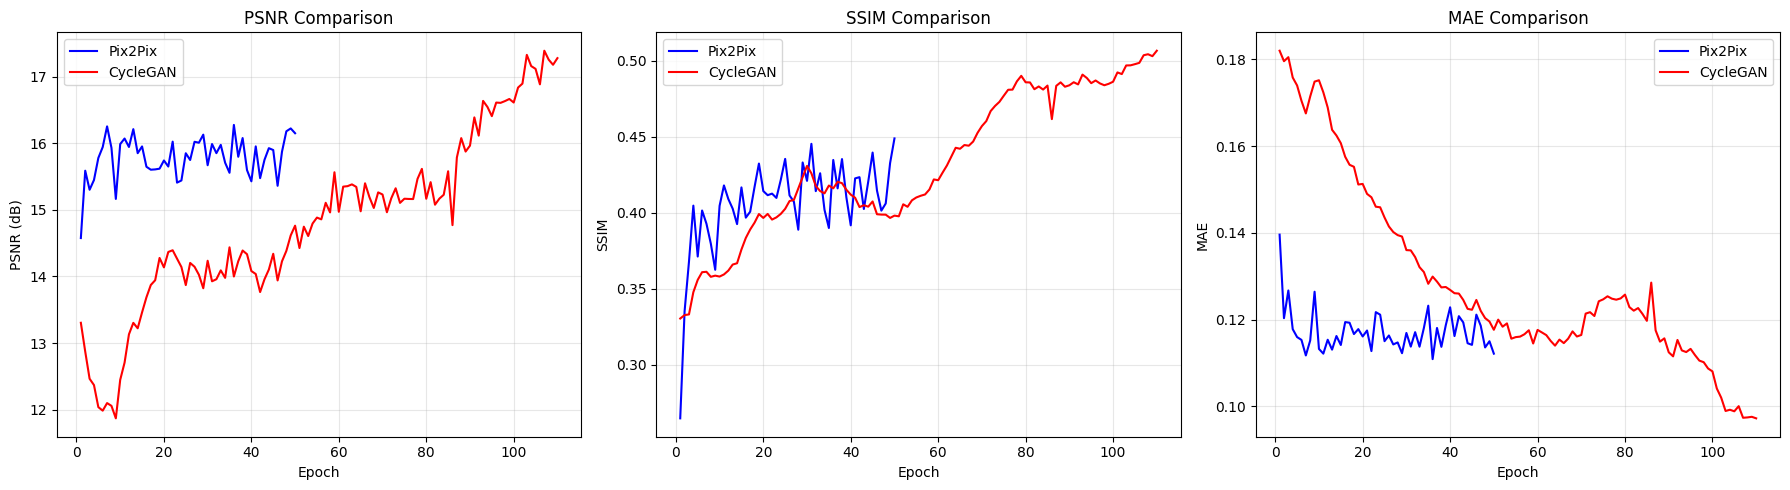


📊 Pix2Pix vs CycleGAN 最终指标对比
Pix2Pix - Final PSNR: 16.15dB, SSIM: 0.4489, MAE: 0.1122
CycleGAN - Final PSNR: 17.28dB, SSIM: 0.5066, MAE: 0.0973


In [ ]:
# 加载Pix2Pix的训练历史（如果存在）
pix2pix_history_path = OUTPUT_ROOT / "logs" / "pix2pix" / "history.json"

if pix2pix_history_path.exists():
    print("📊 加载Pix2Pix训练历史进行对比...")
    with open(pix2pix_history_path, "r") as f:
        pix2pix_history = json.load(f)
    
    # 加载CycleGAN历史
    cyclegan_history_path = LOGS_DIR / "history.json"
    with open(cyclegan_history_path, "r") as f:
        cyclegan_history = json.load(f)
    
    # 对比指标
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    epochs_pix2pix = range(1, len(pix2pix_history.get("val_psnrs", [])) + 1)
    epochs_cyclegan = range(1, len(cyclegan_history["val_psnrs"]) + 1)
    
    # PSNR对比
    axes[0].plot(epochs_pix2pix, pix2pix_history.get("val_psnrs", []), label="Pix2Pix", color="blue")
    axes[0].plot(epochs_cyclegan, cyclegan_history["val_psnrs"], label="CycleGAN", color="red")
    axes[0].set_xlabel("Epoch")
    axes[0].set_ylabel("PSNR (dB)")
    axes[0].set_title("PSNR Comparison")
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # SSIM对比
    axes[1].plot(epochs_pix2pix, pix2pix_history.get("val_ssims", []), label="Pix2Pix", color="blue")
    axes[1].plot(epochs_cyclegan, cyclegan_history["val_ssims"], label="CycleGAN", color="red")
    axes[1].set_xlabel("Epoch")
    axes[1].set_ylabel("SSIM")
    axes[1].set_title("SSIM Comparison")
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    # MAE对比
    axes[2].plot(epochs_pix2pix, pix2pix_history.get("val_maes", []), label="Pix2Pix", color="blue")
    axes[2].plot(epochs_cyclegan, cyclegan_history["val_maes"], label="CycleGAN", color="red")
    axes[2].set_xlabel("Epoch")
    axes[2].set_ylabel("MAE")
    axes[2].set_title("MAE Comparison")
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(FIGURES_DIR / "pix2pix_vs_cyclegan_comparison.png", dpi=150, bbox_inches="tight")
    plt.show()
    
    # 打印最终指标对比
    print("\n" + "=" * 80)
    print("📊 Pix2Pix vs CycleGAN 最终指标对比")
    print("=" * 80)
    print(f"Pix2Pix - Final PSNR: {pix2pix_history.get('val_psnrs', [])[-1]:.2f}dB, "
          f"SSIM: {pix2pix_history.get('val_ssims', [])[-1]:.4f}, "
          f"MAE: {pix2pix_history.get('val_maes', [])[-1]:.4f}")
    print(f"CycleGAN - Final PSNR: {cyclegan_history['val_psnrs'][-1]:.2f}dB, "
          f"SSIM: {cyclegan_history['val_ssims'][-1]:.4f}, "
          f"MAE: {cyclegan_history['val_maes'][-1]:.4f}")
    print("=" * 80)
else:
    print("⚠️  未找到Pix2Pix训练历史，跳过对比分析")
    print(f"   预期路径: {pix2pix_history_path}")
    print("   请先完成Pix2Pix训练后再进行对比")
